This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [19]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [20]:
import optax
import equinox as eqx

from functools import partial

from math import floor

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canoak.physics.energy_fluxes import get_dispersion_matrix

# from jax_canoak.models import CanoakBaseIFT
from jax_canoak.models import CanoakIFT
from jax_canoak.models import get_canle, update_canle
from jax_canoak.models import get_soilresp, update_soilresp

# from jax_canoak.shared_utilities.optim import perform_optimization
from jax_canoak.shared_utilities.optim import perform_optimization_batch
from jax_canoak.shared_utilities import compute_metrics
from jax_canoak.subjects import convert_met_to_batched_met
from jax_canoak.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)
from jax_canoak.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canoak.models import run_canoak_in_batch

# from jax_canoak.models import run_canoak_in_batch_any

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    visualize_tree_diff,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2
from jax_canoak.shared_utilities import tune_jax_naninfs_for_debug

jax.config.update("jax_enable_x64", True)
tune_jax_naninfs_for_debug(False)
# jax.config.update("jax_debug_nans", False)
# jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model parameters and settings

In [21]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
# niter = 1

batch_size = 2
# batch_size = 1274
batch_size = int(74496/2)

site = "US-Bi1"
key = "nodl"

# Calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes.csv"

# Test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-test.csv"

# Load and set the model forcings

In [22]:
met, n_time = get_met_forcings(f_forcing)
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)

timesteps = get_time(met)

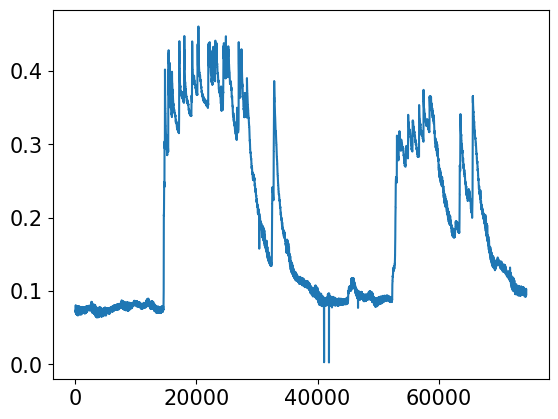

In [23]:
# plt.plot(met.eair_Pa)
# plt.plot(met.es)
# plt.plot(met.lai)
# plt.plot(veg_new.gs)
# plt.plot(met.Tsoil)
plt.plot(met.soilmoisture)

# Load the observations

In [24]:
obs = get_obs(f_obs)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [25]:
# # Read the observations
# f_obs = "../data/fluxtower/US-Bi1/US-Bi1-fluxes.csv"
# obs = pd.read_csv(f_obs)
# obs.interpolate(method="linear", limit_direction="both", inplace=True)
# # obs[obs == -9999] = np.nan
# # obs = jnp.array(obs)

# P_obs = jnp.array(obs["P_F"])
# LE_obs, H_obs = jnp.array(obs["LE_F_MDS"]), jnp.array(obs["H_F_MDS"])
# # LE_obs, H_obs = jnp.array(obs["LE_MODIS"]), jnp.array(obs["H"])
# Gsoil_obs, Rnet_obs = jnp.array(obs["G_F_MDS"]), jnp.array(obs["NETRAD"])
# Rsoil_obs = jnp.array(obs["Rsoil"])

# nan = jnp.nan * jnp.ones(LE_obs.size)
# GPP_obs, albedo_obs, Fco2_obs = nan, nan, nan

# obs = Obs(
#     P_obs, LE_obs, H_obs, GPP_obs, Rnet_obs, albedo_obs, Fco2_obs, Gsoil_obs, Rsoil_obs
# )

# Create the model parameter instance

In [26]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    obs=obs,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

# Generate or read the dispersion matrix

In [27]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, f"../../data/dij/Dij_{site}.csv")
# import numpy as np
# np.savetxt(f"../../data/dij/Dij_{site}.csv", np.array(dij), delimiter=',')

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

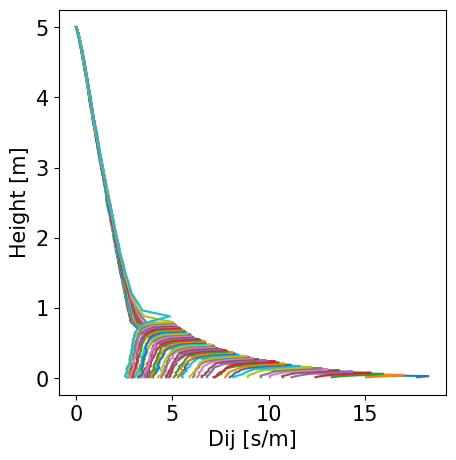

In [28]:
plot_dij(dij, para)

# Run CANOAK!

In [29]:
jax.clear_caches()
canoak_eqx_ift = CanoakIFT(para, setup, dij)
# met, prof, ir, qin, sun, shade, soil, veg, can = canoak_eqx_ift(met)
states, drivers = canoak_eqx_ift(met)
met, prof, ir, qin, sun, shade, soil, veg, can = states
quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


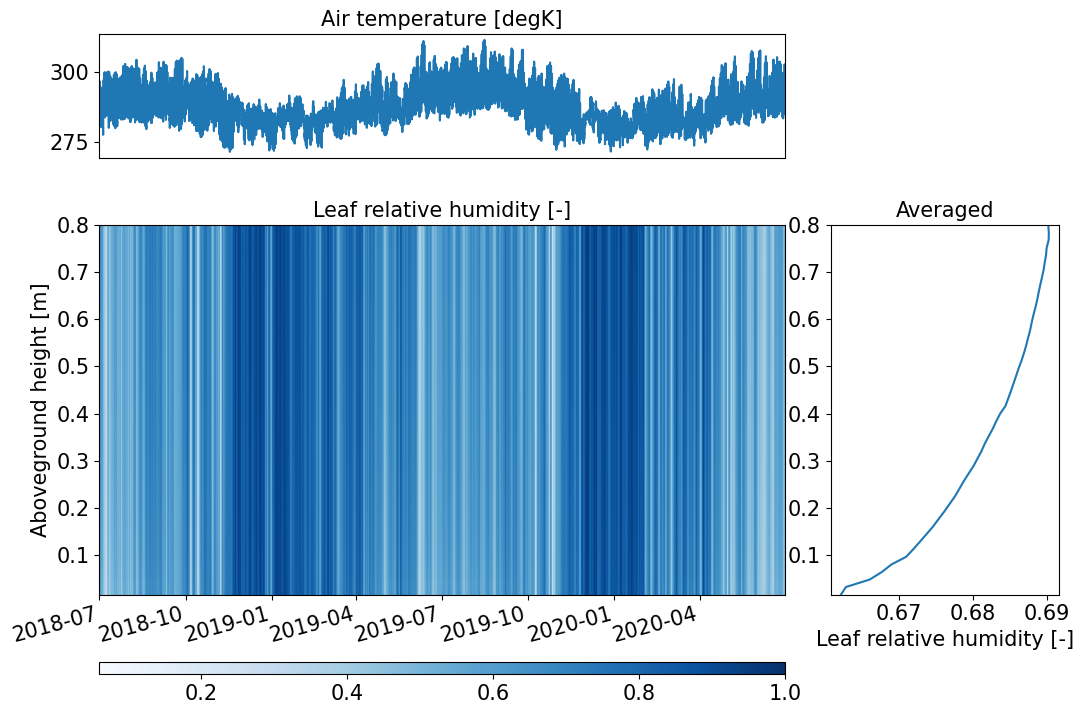

In [30]:
# Leaf relative humidity
plot_imshow2(
    sun.Leaf_RH.T,
    met,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
)

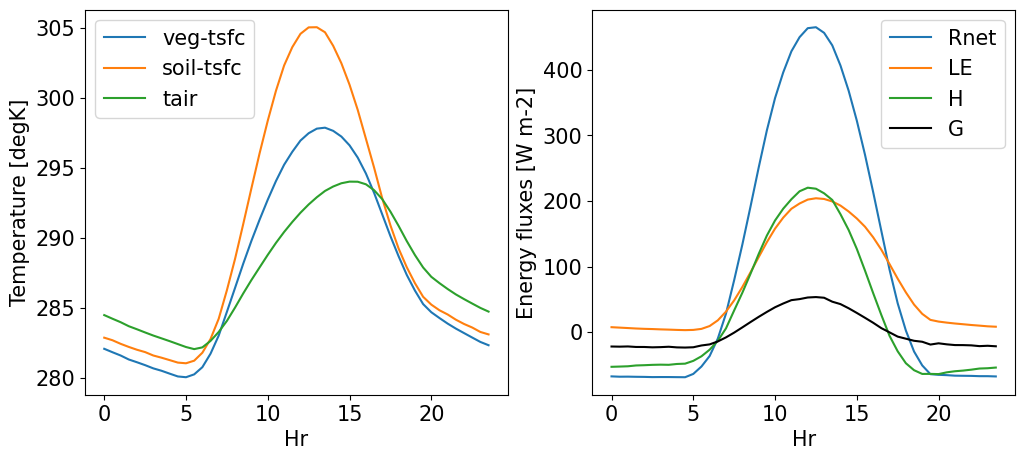

In [31]:
# Daily average
plot_daily(met, soil, veg, para);

In [32]:
# plt.plot(soil.resp, '.')
# plt.plot(veg.Rd, '.')
# veg.Ps[:100], timesteps[:100]

In [33]:
# # plt.plot(soil.resp)
# timesteps = get_time(met)

# fig, ax1, ax2 = plot_timeseries_obs_1to1(
#     obs.Rsoil,
#     soil.resp,
#     # veg.Ps,
#     lim=[-2, 6],
#     met=met,
#     varn="Soil respiration ",
#     linestyle=".",
# )
# ax1.set(ylabel="[umol m-2 s-1]")
# ax12 = ax1.twinx()
# # ax12.invert_yaxis()
# # ax12.plot(timesteps, veg.Ps, "k", alpha=0.5)
# # ax12.plot(timesteps, met.CO2, "k", alpha=0.5)
# # ax12.plot(timesteps, met.Tsoil, "k", alpha=0.5)
# ax12.plot(timesteps, met.soilmoisture, "k", alpha=0.5)
# # ax12.plot(timesteps, soil.sfc_temperature, "k")
# # ax12.plot(timesteps, obs.P, "k")
# # ax12.plot(timesteps, obs.P, "k")
# # ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

In [22]:
# Analyze nan
nanind = jnp.where(jnp.isnan(prof.Tair_K.mean(axis=1)))

met.lai[nanind]
# qin.sun_abs[nanind]
# ir.ir_in[nanind]
sun.Tsfc[nanind, :]

Array([], dtype=float64)

In [24]:
# plot_rad(quantum, setup, lai, "PAR")
# plot_rad(nir, setup, lai, "nir")
# plot_ir(ir, setup, lai)

In [25]:
# # Profiles
# plot_imshow2(
#     prof.Tair_K.T,
#     met,
#     para.zht,
#     key="T",
#     title="Temperature profile [degk]",
#     cmap="turbo",
# )
# plot_imshow2(
#     prof.eair_Pa.T, met, para.zht, key="e", title="Pressure profile [Pa]", cmap="turbo"
# )
# plot_imshow2(
#     prof.co2.T, met, para.zht, key="co2", title="CO2 profile [ppm]", cmap="turbo"
# )

In [26]:
# # Temperature
# plot_imshow2(
#     sun.Tsfc.T, met, para.zht1, key="T", title="Sunlit leaf temp [degk]", cmap="turbo"
# )
# plot_imshow2(
#     shade.Tsfc.T, met, para.zht1, key="T", title="Shaded leaf temp [degK]", cmap="turbo"
# )
# plot_imshow2(
#     soil.T_soil[:, :-1].T,
#     met,
#     soil.z_soil,
#     key="T",
#     title="Soil temp [degK]",
#     cmap="turbo",
#     is_canopy=False,
# )

In [27]:
# # respiration/photosynthesis
# plot_imshow2(
#     sun.Ps.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Sunlit leaf photosynthesis \n [umol m-2 s-1]",
#     cmap="turbo",
# )
# plot_imshow2(
#     shade.Ps.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Shaded leaf photosynthesis \n [umol m-2 s-1]",
#     cmap="turbo",
# )
# plot_imshow2(
#     sun.Resp.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Sunlit leaf respiration \n [umol m-2 s-1]",
#     cmap="turbo",
# )
# plot_imshow2(
#     shade.Resp.T,
#     met,
#     para.zht1,
#     key="co2",
#     title="Shaded leaf respiration \n [umol m-2 s-1]",
#     cmap="turbo",
# )

In [14]:
# met2 = jax.tree_util.tree_map(lambda x: x.reshape(1,816), met)
# jax.vmap(canoak, in_axes=[None,None,0,None,None,None])(para, setup, met2,
#    dij, setup.soil_mtime, setup.niter)

# Local sensitivity analysis

In [52]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    can_le = canoak_eqx.get_fixed_point_states(met, update_canle, get_canle)
    # met, update_soilresp, get_soilresp)
    return can_le.sum()


@eqx.filter_jit
def df_canoak_le_batched(para, batched_met, canoak_eqx):
    def compute_grad(para, met):
        grad = df_canoak_le(para, met, canoak_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients


# eqx.filter_make_jaxpr(df_canoak_le3)(para, met, canoak_eqx)

## Perform SA at one time step

In [53]:
start, ntime = 20, 1
met2 = jtu.tree_map(lambda x: x[start : start + ntime], met)

In [54]:
gradients = df_canoak_le(para, met2, canoak_eqx_ift)

In [55]:
gradients.lleaf

Array(-20.70639241, dtype=float64, weak_type=True)

## Perform SA at multiple steps

In [56]:
jax.clear_caches()
batched_met_sa = convert_met_to_batched_met(met, n_time, 1)
gradients = df_canoak_le_batched(para, batched_met_sa, canoak_eqx_ift)

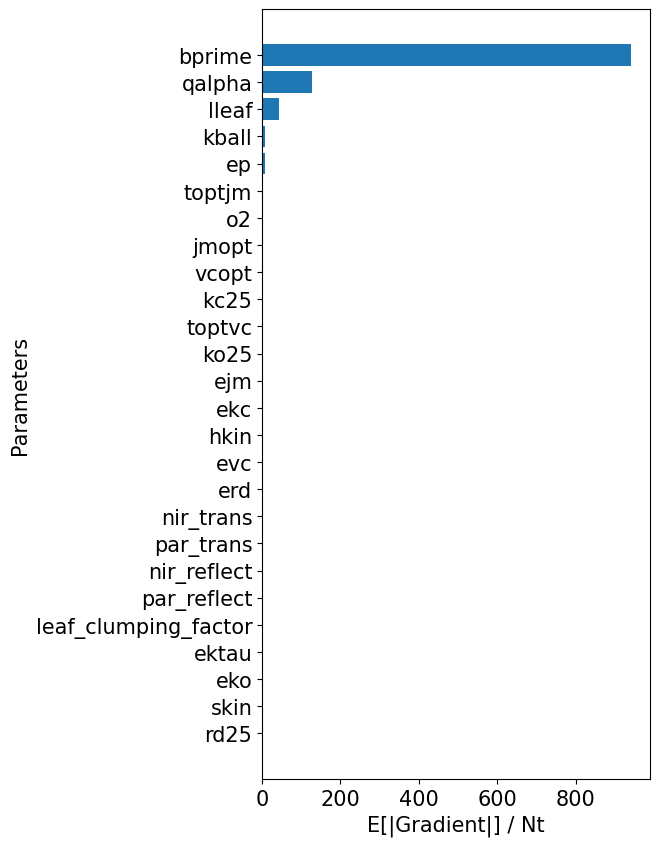

In [57]:
plot_para_sensitivity_ranking(gradients, category="photosyn")
# plot_para_sensitivity_ranking(gradients, category=None)

In [40]:
# gm = jtu.tree_map(lambda x:x.mean(), gradients)
# a, b = jtu.tree_flatten(gm)

In [75]:
# bb = b.node_data()[1]
# names = bb.dynamic_field_names

# Comparison with the observations

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

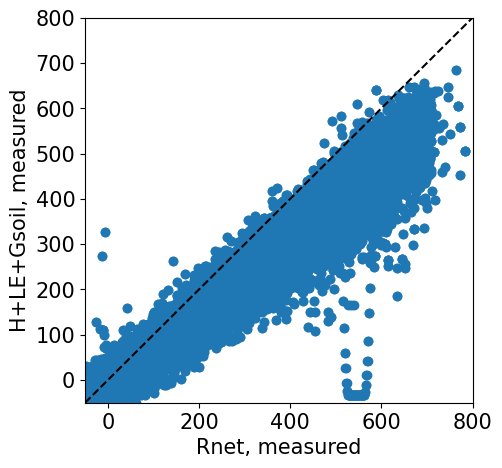

In [36]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 1371.509)'}, xlabel='Measured', ylabel='Simulated'>

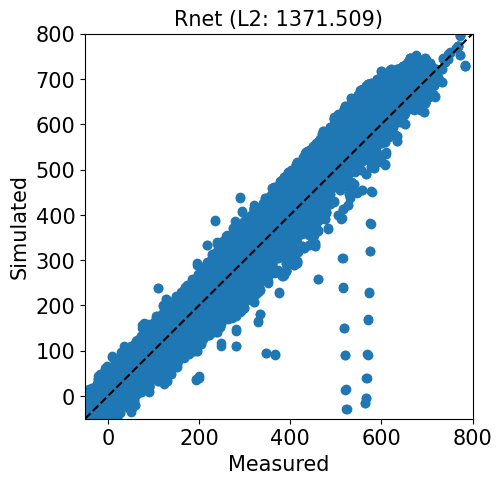

In [38]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

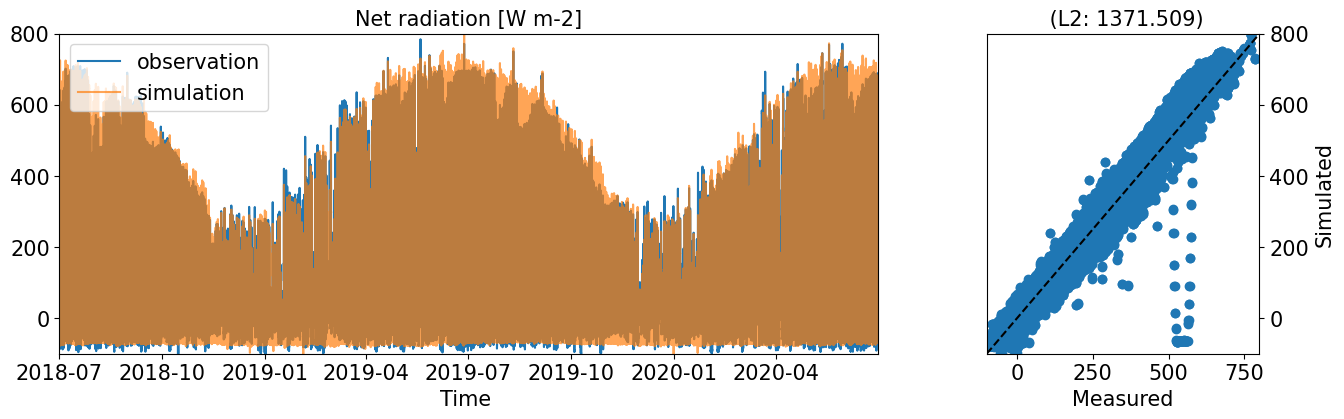

In [39]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    met=met,
    varn="Net radiation [W m-2]",
);

In [40]:
# plt.figure(0)
# plt.plot(obs.P)
# plt.figure(1)
# plt.plot(obs.Rsoil)
# plt.figure(1)
# plt.plot(soil.resp)

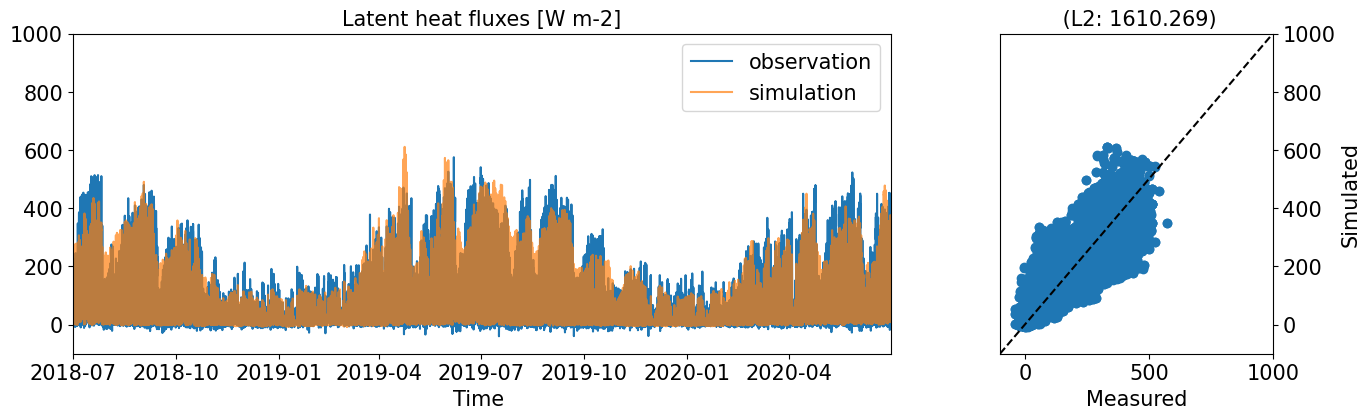

In [41]:
plot_timeseries_obs_1to1(
    obs.LE,
    can.LE,
    lim=[-100, 1000],
    met=met,
    varn="Latent heat fluxes [W m-2]",
);

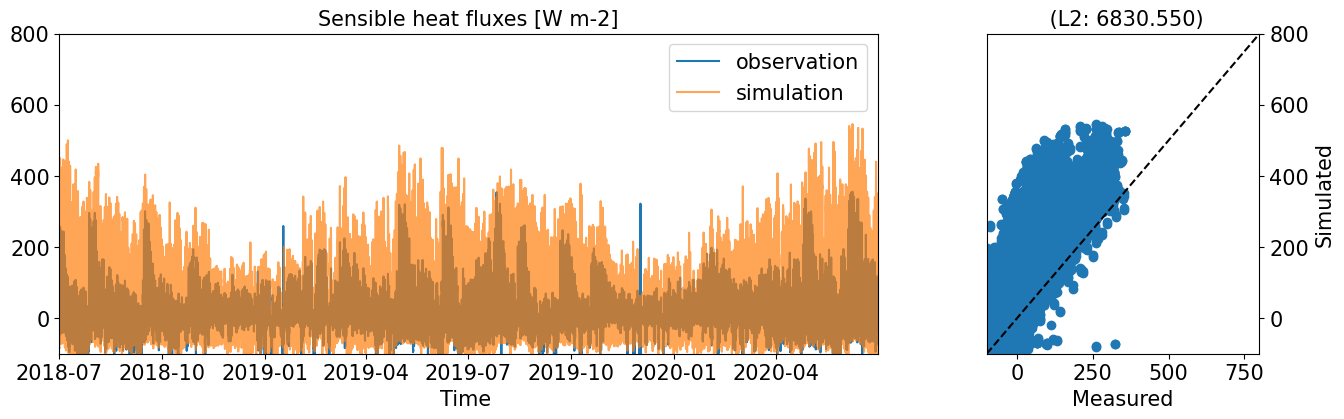

In [42]:
plot_timeseries_obs_1to1(
    obs.H,
    can.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
);

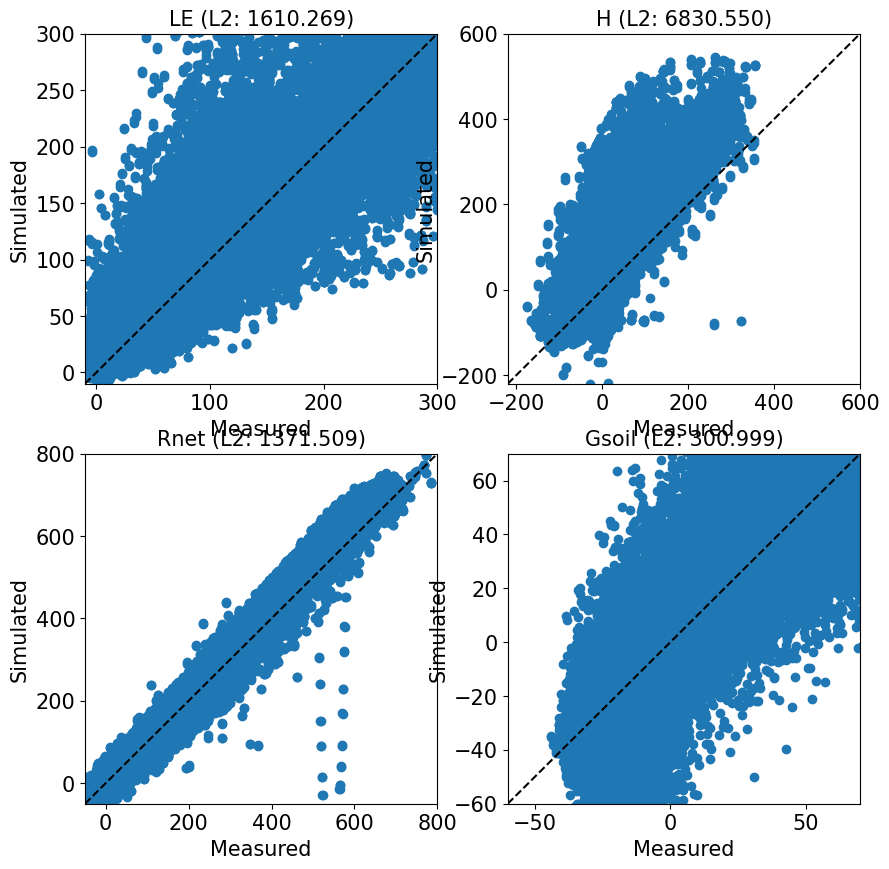

In [43]:
plot_obs_comparison(obs, can);

# Perform parameter estimation

In [34]:
# Filter the parameters to be estimated
filter_model_spec = jtu.tree_map(lambda _: False, canoak_eqx_ift)
filter_model_spec = eqx.tree_at(
    lambda t: (
        t.para.bprime,
        # t.para.ep,
        t.para.lleaf,
        t.para.qalpha,
        t.para.kball,
        # t.para.leaf_clumping_factor,
    ),
    filter_model_spec,
    replace=(True, True, True, True),
)

In [36]:
# Define optimizer and observations
args = [update_canle, get_canle]
nsteps = 500  # number of epoches
# nsteps = 100  # number of epoches
batched_obs = convert_obs_to_batched_obs(obs, n_batch, batch_size)
batched_y = batched_obs.LE
scheduler = optax.piecewise_constant_schedule(
    0.01, boundaries_and_scales={50: 0.5, 100: 0.5, 200: 0.5}
)
# scheduler = optax.exponential_decay(0.01, transition_steps=30, decay_rate=0.1)
# optim = optax.adam(learning_rate=scheduler)  # Adam optimizer
optim = optax.adam(learning_rate=scheduler)  # Adam optimizer
# optim = optax.adam(learning_rate=0.01)  # Adam optimizer

batched_obs = convert_obs_to_batched_obs(obs, n_batch, batch_size)
batched_y = batched_obs.LE

In [37]:
# jax.clear_caches()
args = [update_canle, get_canle]
canoak_eqx_new, loss_set = perform_optimization_batch(
    canoak_eqx_ift.get_fixed_point_states,
    filter_model_spec.get_fixed_point_states,
    optim,
    batched_y,
    batched_met,
    nsteps,
    # 59,
    para_min,
    para_max,
    *args,
)
# canoak_eqx_new = canoak_eqx_new.args[0]
canoak_eqx_new = canoak_eqx_new.__self__

Argument model is triggering a compile.
Argument filter_model_spec is triggering a compile.
Argument batched_y is triggering a compile.
Argument opt_state is triggering a compile.
Argument batched_met is triggering a compile.
Compiling make_step ...
The loss of step 0: 1609.3073068565425
Argument model is triggering a compile.
Argument opt_state is triggering a compile.
Compiling make_step ...
The loss of step 1: 1627.6700560042723
The loss of step 2: 1543.763092363074
The loss of step 3: 1530.5325386926265
The loss of step 4: 1531.5775500117243
The loss of step 5: 1512.5167585712907
The loss of step 6: 1490.964461383804
The loss of step 7: 1486.3866333534077
The loss of step 8: 1500.0537669843147
The loss of step 9: 1506.588989639445
The loss of step 10: 1502.125770611508
The loss of step 11: 1495.2492316917442
The loss of step 12: 1495.5474058897348
The loss of step 13: 1500.4707084207485
The loss of step 14: 1504.0770553000032
The loss of step 15: 1503.6766034479742
The loss of step

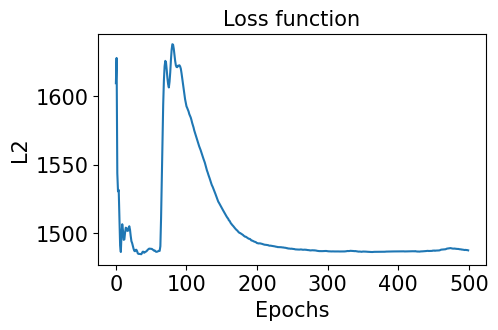

In [38]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(loss_set)
ax.set(xlabel="Epochs", ylabel="L2", title="Loss function", yscale="linear");

## Rerun the model using the estimated parameters

### Calibration period

In [39]:
states, drivers = canoak_eqx_new(met)
(
    met_new,
    prof_new,
    ir_new,
    qin_new,
    sun_new,
    shade_new,
    soil_new,
    veg_new,
    can_new,
) = states
# quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

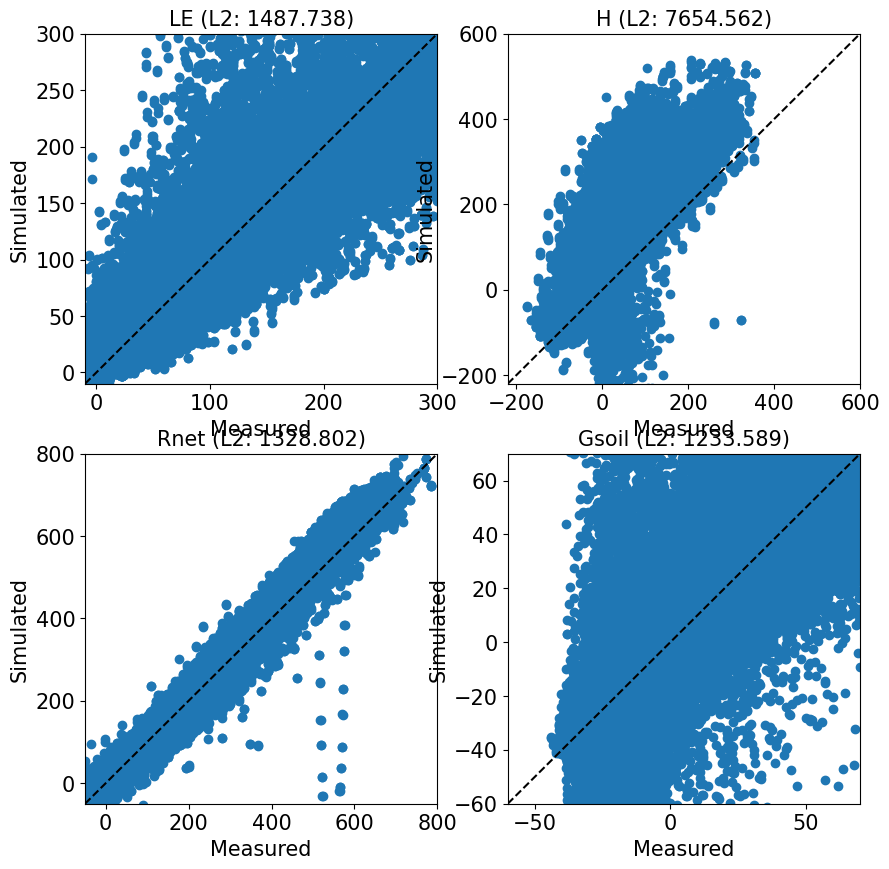

In [40]:
plot_obs_comparison(obs, can_new);

### Test period

In [41]:
# Read the observations
met_test, n_time_test = get_met_forcings(f_forcing_test)
timesteps_test = get_time(met_test)

# Read the observations
obs_test = get_obs(f_obs_test)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [42]:
states_test, drivers_test = canoak_eqx_new(met_test)
(
    _,
    prof_test,
    ir_test,
    qin_test,
    sun_test,
    shade_test,
    soil_test,
    veg_test,
    can_test,
) = states_test

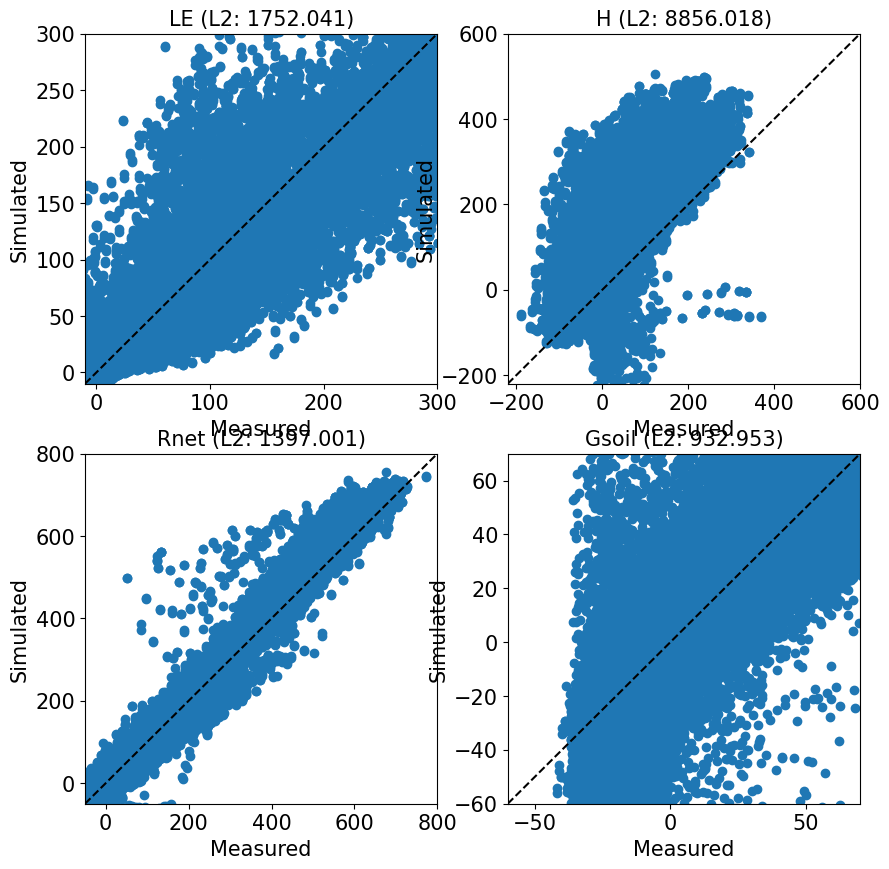

In [43]:
plot_obs_comparison(obs_test, can_test);

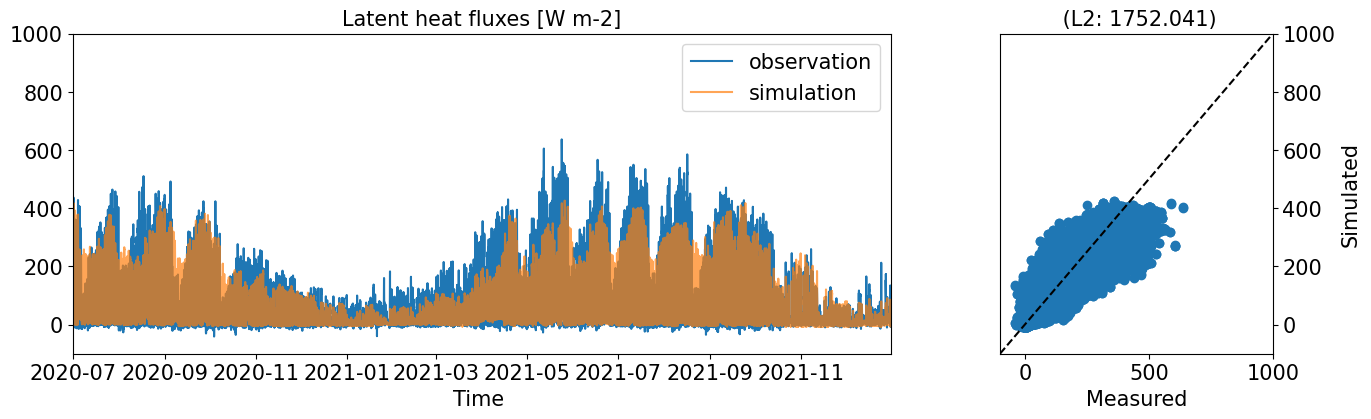

In [44]:
plot_timeseries_obs_1to1(
    obs_test.LE,
    can_test.LE,
    lim=[-100, 1000],
    met=met_test,
    varn="Latent heat fluxes [W m-2]",
);

In [45]:
metrics = compute_metrics(obs.LE, can_new.LE)
metrics_test = compute_metrics(obs_test.LE, can_test.LE)
print(metrics)
print(metrics_test)

{'rmse': 38.57121047878536, 'mse': 1487.7382777987616, 'r2': 0.8697822408532191, 'kge': 0.9110326282003126, 'nse': 0.8543871680658681, 'mkge': 0.9170473509665747, 'cc': 0.932731143770189, 'alpha': 1.0093929783327868, 'beta': 1.0476215804151379}
{'rmse': 41.857389296813075, 'mse': 1752.0410387449617, 'r2': 0.8532600954481842, 'kge': 0.8021820515807192, 'nse': 0.8006437999304343, 'mkge': 0.8661063517800149, 'cc': 0.9275579760134253, 'alpha': 1.0804272284722511, 'beta': 1.078810678937933}


## Save the outputs

In [48]:
import pickle

# out = {"model": canoak_eqx_new, "out": states, "out_test": states_test, "obs": obs, "obs_test": obs_test}
train = {
    "time": timesteps,
    "can.LE": can_new.LE,
    "sun.gs": sun_new.gs,
    "shade.gs": shade_new.gs,
    "sun.Ps": sun_new.Ps,
    "shade.Ps": shade_new.Ps,
    "can.H": can_new.H,
    "can.rnet": can_new.rnet,
    "can.gsoil": can_new.gsoil,
    "sun.Tlk": sun_new.Tsfc,
    "shade.Tlk": shade_new.Tsfc,
    "sun.Leaf_RH": sun_new.Leaf_RH,
    "shade.Leaf_RH": shade_new.Leaf_RH,
    "soil.Tsoil": soil_new.T_soil,
}
test = {
    "time": timesteps_test,
    "can.LE": can_test.LE,
    "sun.gs": sun_test.gs,
    "shade.gs": shade_test.gs,
    "sun.Ps": sun_test.Ps,
    "shade.Ps": shade_test.Ps,
    "can.H": can_test.H,
    "can.rnet": can_test.rnet,
    "can.gsoil": can_test.gsoil,
    "sun.Tlk": sun_test.Tsfc,
    "shade.Tlk": shade_test.Tsfc,
    "sun.Leaf_RH": sun_test.Leaf_RH,
    "shade.Leaf_RH": shade_test.Leaf_RH,
    "soil.Tsoil": soil_test.T_soil,
}
out = {"train": train, "test": test}
pickle.dump(out, open(f"{site}_{key}.pkl", "wb"), pickle.HIGHEST_PROTOCOL)
